# Align different filters, move to ra dec coordinates and calibrate flux using GAIA data

1. Account for dithering between the five different filters
2. Use Astometry.net to recognize stars in the field and create a map (x,y)-> (ra,dec)
3. Tranform axes from pixels to ra,dec
4. Do the calibration using GAIA data of the stars in the field, and transform counts/s in specific flux units erg/cm^2 s armstrong

In [4]:
import numpy as np
from matplotlib import pyplot as plt

import os
import gc
import warnings
warnings.filterwarnings('ignore')

OBSERVATIONS

g:  3x120s\
r:  3x120s\
i:  3x120s\
Ha: 1x900s + 4x300s\
Hb: 4x1200s

In [5]:
from astropy.io import fits

filter = ['Ha', 'Hb', 'g', 'r', 'i']
file_paths = {f: f'data/cleaned_not_calibrated/{f}_filter_science.fit' for f in filter}

obs_time = {'Ha': 900, 'Hb': 4800, 'g': 120, 'r': 120, 'i': 120}

filter_cmap = {'Ha': 'gnuplot2', 'Hb': 'pink', 'g': 'bone', 'r': 'hot', 'i': 'copper'}

image = {f: fits.getdata(path) for f, path in file_paths.items()}
for f in filter:
    image[f] = image[f] / obs_time[f]  



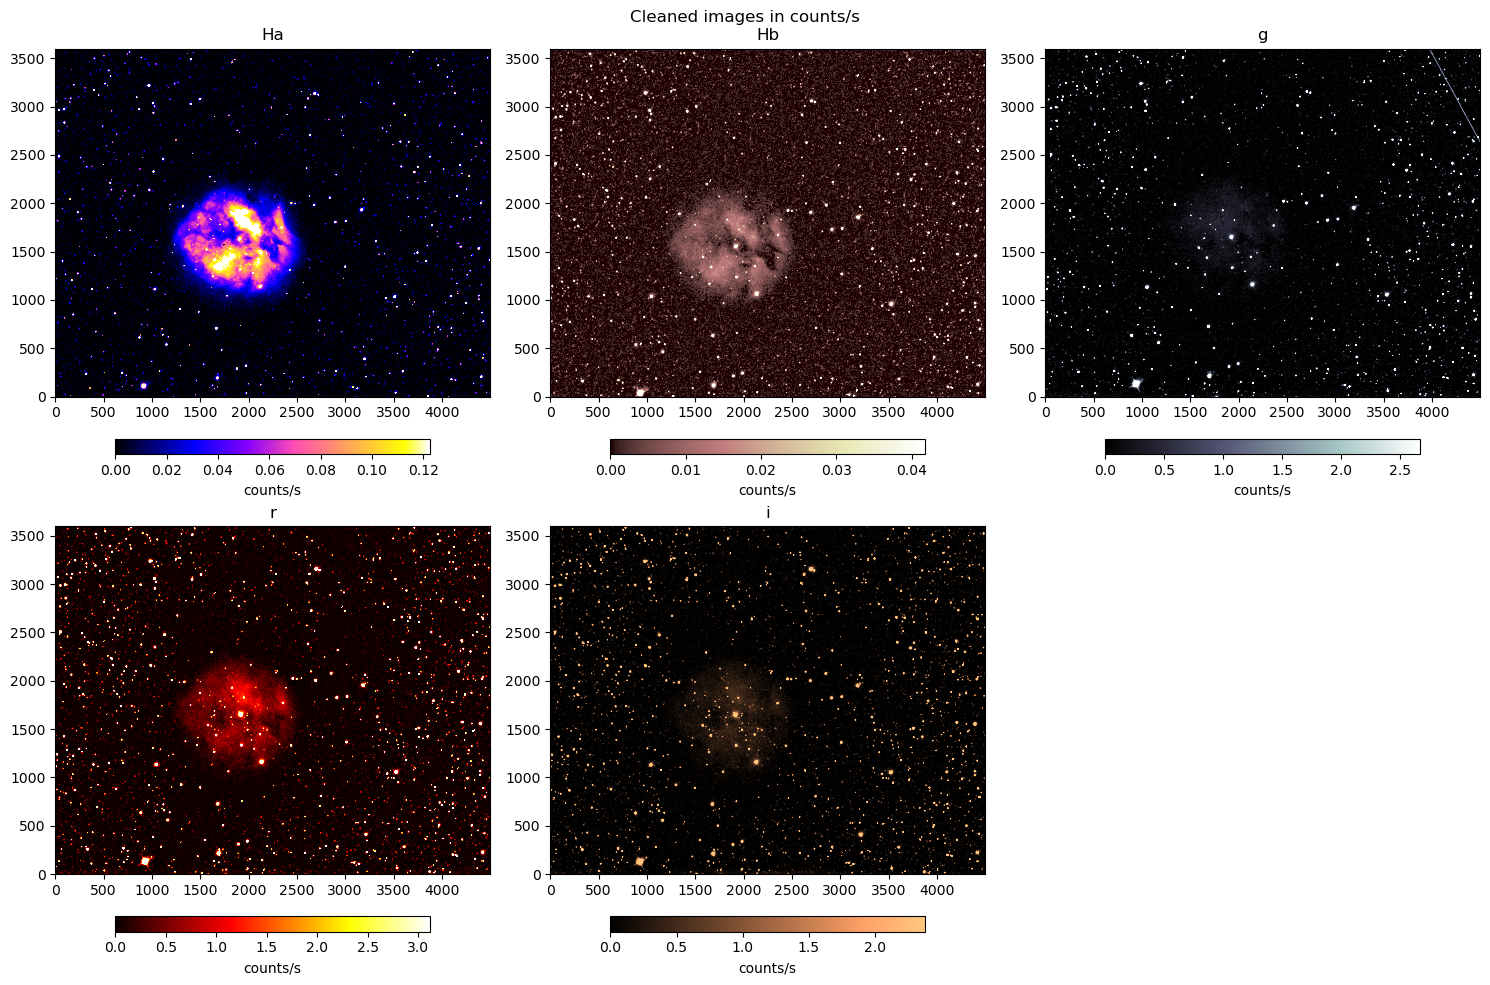

In [3]:

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Cleaned images in counts/s")
axes = axes.flatten()

for i, f in enumerate(filter):
    im = axes[i].imshow(image[f], clim=[0, np.quantile(image[f], 0.99)], cmap=filter_cmap[f], origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1, label="counts/s")
    axes[i].set_title(f)

axes[-1].axis('off')

plt.tight_layout()
plt.show()



## Dithering

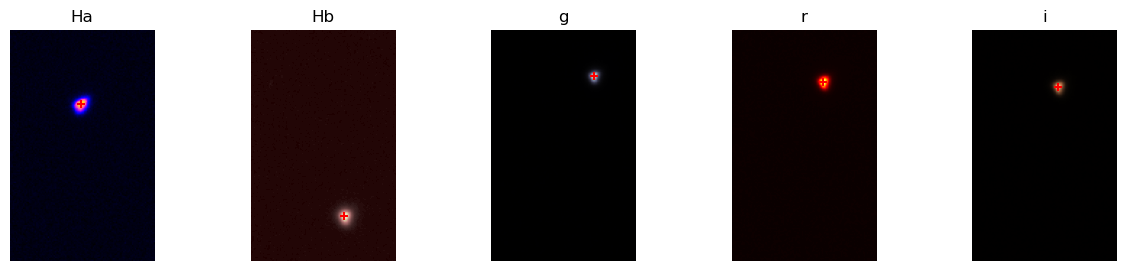

In [6]:
from photutils.centroids import centroid_quadratic

star_centroid = []

x_sx = 2850
x_dx = 2950
y_sx = 1700
y_dx = 1860

fig, ax = plt.subplots(1, 5, figsize=(15, 3))  # Create 1x5 grid

for i, f in enumerate(filter):
    rectangle = image[f][y_sx:y_dx, x_sx:x_dx]
    
    # Calculate centroid
    centroid = centroid_quadratic(rectangle)
    star_centroid.append(centroid)
    
    im = ax[i].imshow(rectangle, cmap=filter_cmap[f], origin='lower', aspect='equal')
    ax[i].scatter(centroid[0], centroid[1], marker='+', color='red')  # Mark centroid
    ax[i].set_title(f)
    ax[i].axis("off")


In [7]:
#print(star_centroid)
offsets = np.round(star_centroid[0] - star_centroid).astype(int) # refered to first exposure 
#print(offsets)

In [8]:
# align the image

for i, f in enumerate(filter):

    image[f] = np.roll(image[f], (offsets[i, 0], offsets[i, 1]), axis=(1, 0))

# save one fit file for Astrometry.net
hdu = fits.PrimaryHDU(image['r'])
hdu.writeto('data/r_aligned.fit', overwrite=True)

#del image
#gc.collect();

In [9]:
# Stars recognized by ASTROMETRY.NET  https://nova.astrometry.net/upload
# x,y coordinates on detector and ra dec coordinates 

stars_astrometry = []

with fits.open("data/astrometry.fit") as hdul:
    if len(hdul) > 1:
        table_hdu = hdul[1]  

        if table_hdu.data.ndim == 1:
            table = np.stack(table_hdu.data)

        for row in table:
            stars_astrometry.append({'ra': row[0], 'dec': row[1], 'x': row[2], 'y': row[3]})



In [10]:
import pandas as pd

df = pd.DataFrame(stars_astrometry)
print(df.head(5))

           ra        dec            x            y
0  328.653284  47.155646   917.849304   113.173172
1  328.524359  47.122717  1677.976318   197.887039
2  328.161412  47.111895  3513.032471  1038.789429
3  328.142092  47.228769  3170.979980  1936.058228
4  328.264156  47.059291  3201.657471   395.491486


## CALIBRATION

**VEGA MAGNITUDES**

Uses Vega as reference. UBVRI filters system. Tied to the specific spectral energy distribution (SED) of Vega, making it less uniform across different passbands

$f_\nu$ is specific spectral flux density 

% V band magnitude:
$$m_{\text{V}} = -2.5 \log_{10} \left( \frac{f_{\text{,V}}}{f_{0\text{,V}}} \right)$$

% R band magnitude:
$$m_{\text{R}} = -2.5 \log_{10} \left( \frac{f_{\text{,R}}}{f_{0\text{,R}}} \right)$$




**AB MAGNITUDES**

Based on flux measurements that are calibrated in absolute units. "Flat" system in terms of the logarithmic scale for energy.
Magnitudes are still related to one spectral filter!

$f_\nu$ is specific spectral flux density 

% Monochromatic AB magnitude:
$$m_{\text{AB}} \approx -2.5 \log_{10} \left( \frac{f_{\nu}}{3631 \, \text{Jy}} \right)$$

% Simplified expression (with f_nu in Jansky):
$$m_{\text{AB}} = -2.5 \log_{10} f_{\nu} + 8.90$$

% Exact definition in cgs units:
$$m_{\text{AB}} = -2.5 \log_{10} f_{\nu} - 48.60$$

% Zero-point flux density:
$$f_{\nu,0} = 10^{\frac{48.60}{-2.5}} \approx 3.631 \times 10^{-20} \, \text{erg} \, \text{s}^{-1} \, \text{cm}^{-2} \, \text{Hz}^{-1}$$

% Bandpass AB magnitude:
$$m_{\text{AB}} \approx -2.5 \log_{10} \left( \frac{\int f_{\nu} (h \nu)^{-1} e(\nu)\, d\nu}{\int 3631 \, \text{Jy} \, (h\nu)^{-1} e(\nu) \, d\nu} \right)
$$

**FILTER TRANSMISSION**

Although SDSS (or other surveys) dispaly ugriz filter data, filters on TOBI are most probably different, because of different trasmission of the filter and also different response of the detector to different wavelength (different quantum efficiency). At first order the rapresentative wavelength of a filter is:

$$\lambda_\text{filter} = \frac{\lambda_{max}-\lambda_{min}}{2}$$

This works fine only when the filter is flat. A better definition is the effective wavelength, which is like a "mean" wavelength describing the filter's shape

$$\lambda_{eff} = \frac{\int T(\lambda) \lambda \, d\lambda}{\int T(\lambda) d\lambda}$$

Even better is the pivotal wavelength, which minimizes the difference between flux density in $f_\lambda$ and $f_\nu$ within the filter. It is defined as:

$$\lambda_{pivot} = \sqrt{\frac{\int T(\lambda) \lambda\, d\lambda}{\int \frac{T(\lambda)}{\lambda} \, d\lambda}}$$

and combines both the linear and inverse dependence on wavelength.

The convolution of the spectra with the filter's transmission + Q.E. gives the specific flux (which doesn't depend directly on the width or on the height of the filter curve, beeing normalized): 

$$f_{\lambda,V}\approx \frac{\int d\lambda T(\lambda)f(\lambda)}{\int d\lambda T(\lambda)}$$

it's a covolution, weighting. Important: two filters with the same centroid but different bandwidth or different heights will give the same specific flux $f_\lambda$. Of course the broader filter, or the higher, will give higher electron count rate ans so higher SNR.


Specific fluxes conversion: $f_\lambda d\lambda = f_\nu d\nu$ and $\nu\lambda = c$ gives $f_\lambda = f_\nu c/\lambda^2$ 

**INSTRUMENTAL RESPONSE**

C depends on the instrument and on the FILTER. It changes with time, mainly because of dust. Converts a flux in erg/cm^2s^1A^2 in electron per second rate. Analogic digital converter then gives DU. C is called ZERO POINT. 

$$f_\lambda = 10^{-C} N_e$$   integrated over the band

taking the log and multiplying left and right by -2.5:

$$-2.5\log(f_\lambda) = 2.5C - 2.5\log(N_e)$$

the term on left is the apparent magnitude of the source (real flux), while the first term on right is referred to as "zero point" and the second term as instrument magnitude:

$$m_{true} = Z.P. + m_i$$


**Filters on TOBI telescope**

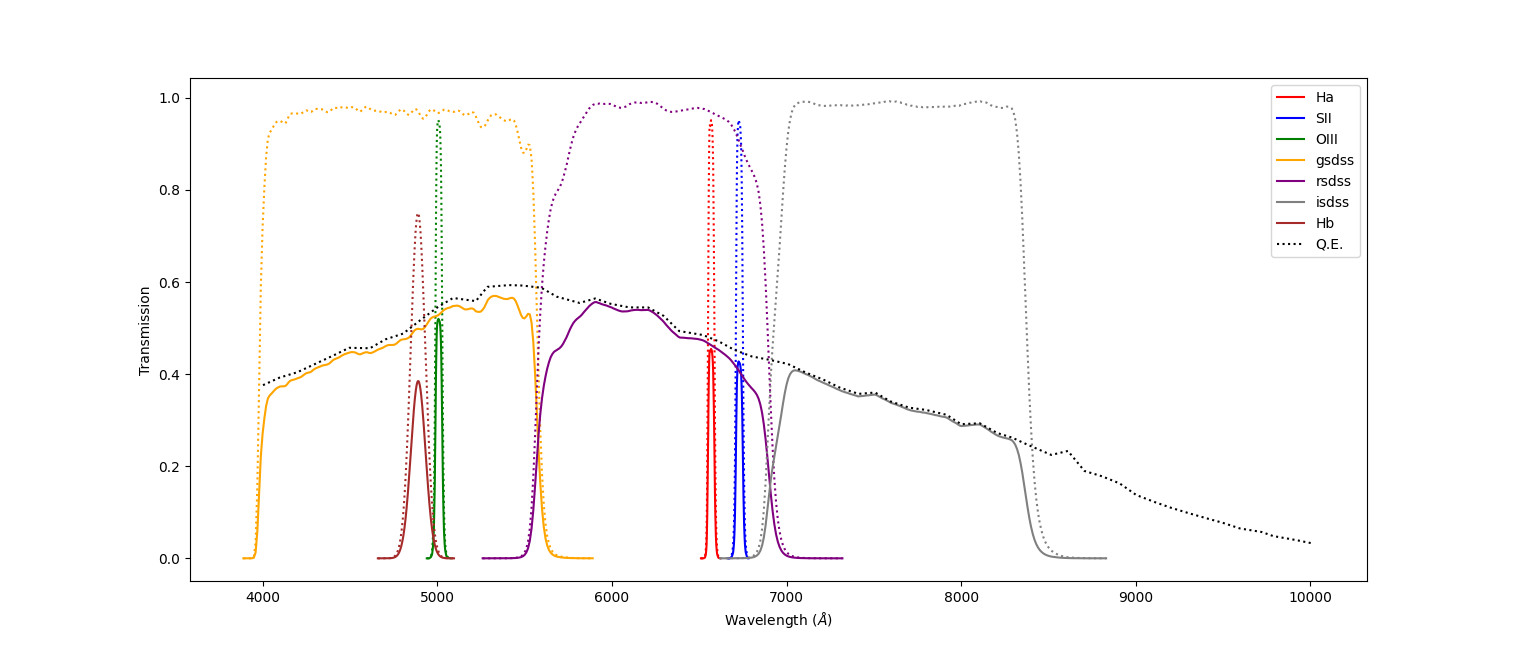

In [11]:
filter_ = ['Ha', 'i', 'g', 'r', 'Hb']

file_paths = [
    'data/filters/tobi_ha.dat',
    'data/filters/tobi_isdss.dat',
    'data/filters/tobi_gsdss.dat',
    'data/filters/tobi_rsdss.dat',
    'data/filters/tobi_hb.dat'
]

filter_transmission = {}
for f, file_path in zip(filter_, file_paths):
    data = np.loadtxt(file_path)
    
    x = data[:, 0]  
    y = data[:, 1]  
    filter_transmission[f] = {'wavelength': x, 'transmission': y}


### Filter color transformations

TOBI_ha = SDSS_r -0.2568 * (SDSS_g-SDSS_r) + 0.1470

TOBI_hb =  SDSS_g -0.2322 * (SDSS_g-SDSS_r) + -0.0024

TOBI_g   = SDSS_g -0.1205 * (SDSS_g-SDSS_r) + 0.0012

TOBI_r    = SDSS_r -0.0061 * (SDSS_g-SDSS_r) + 0.0001

TOBI_i    = SDSS_i -0.0609 * (SDSS_r-SDSS_i) + 0.0049

In [12]:
def TOBI_Ha(sdss_r,sdss_g):
    return sdss_r - 0.2568 * (sdss_g - sdss_r) + 0.1470

def TOBI_Hb(sdss_r,sdss_g):
    return sdss_g - 0.2322 * (sdss_g - sdss_r) - 0.0024

def TOBI_g(sdss_r,sdss_g):
    return sdss_g - 0.1205 * (sdss_g - sdss_r) + 0.0012

def TOBI_r(sdss_r,sdss_g):
    return sdss_r - 0.0061 * (sdss_g - sdss_r) + 0.0001

def TOBI_i(sdss_r,sdss_i):
    return sdss_i - 0.0609 * (sdss_r - sdss_i) + 0.0049


# SDSS

In [13]:
# SDSS

# Sloan Digital Sky Survey 
# Dataset contains only magnitudes in three filters
# Magnitudes values are not reliable, probably due to the fact that the stars lie in the galactic plane, a region highly affected by
# dust extinction, not the focus of SDSS extragalactic survey

file_path = "/home/robertoinfurna/Downloads/asu(5).fit"

stars_sdss = []

with fits.open(file_path) as hdul:
    if len(hdul) > 1:
        table_hdu = hdul[1]  

        for ra, dec, rmag, gmag, imag in zip(table_hdu.data['RA_ICRS'] , table_hdu.data['DE_ICRS'], 
                                             table_hdu.data['rmag'], table_hdu.data['gmag'], table_hdu.data['imag']):
            stars_sdss.append({
                'ra': ra,     # Right Ascension
                'dec': dec,   # Declination
                'r': rmag,    # r-band magnitude
                'g': gmag,    # g-band magnitude
                'i': imag     # i-band magnitude
            })


In [14]:
import pandas as pd

df = pd.DataFrame(stars_sdss)
print(df.head(5))

           ra        dec       r       g       i
0  328.483348  46.948540  14.761  14.924  14.688
1  328.635523  46.980694  14.173  14.356  14.105
2  328.621296  46.954329  14.149  14.138  16.213
3  328.612178  46.949804  14.393  14.744  14.745
4  328.644412  46.979664  14.131  14.371  14.416


# GAIA dataset

The convolution of the spectra with the filter's transmission + Q.E. gives the specific flux (which doesn't depend directly on the width or on the height of the filter curve, beeing normalized): 

$$f_{\lambda,V}\approx \frac{\int d\lambda T(\lambda)f(\lambda)}{\int d\lambda T(\lambda)}$$

it's a covolution, weighting. Important: two filters with the same centroid but different bandwidth or different heights will give the same specific flux $f_\lambda$. Of course the broader filter, or the higher, will give higher electron count rate ans so higher SNR.

In [15]:
# gives flux in filter, given the transmission and the spectra

from scipy.integrate import quad
from scipy.interpolate import interp1d

def specific_flux_lambda(spectrum_wavelength,flux,transmission_wavelength,transmission):
    """
    Convolution of spectra by filter transmission and Q.E.
    Works with specific flux per unit of wavelength and transmission curve defined in wavelength domain (armstrong)
    """
    spectrum = interp1d(spectrum_wavelength, flux, kind='linear', fill_value="extrapolate")
    transmission = interp1d(transmission_wavelength, transmission, kind='linear', fill_value="extrapolate")

    flux_per_transmission, error = quad(lambda w: spectrum(w)*transmission(w), 4000, 9000)
    norm, error = quad(lambda w: transmission(w), 4000, 9000)

    return flux_per_transmission/norm 

def lambda_pivot(transmission_wavelength,transmission):
    """
    wavelengths expressed in armstrong
    """
    transmission = interp1d(transmission_wavelength, transmission, kind='linear', fill_value="extrapolate")
    numerator,error = quad(lambda w: w*transmission(w), 4000, 9000)
    denominator,error = quad(lambda w: transmission(w)/w, 4000, 9000)

    return np.sqrt(numerator/denominator)

# AM I SURE ?!
def magnitude(spectrum_wavelength,flux,transmission_wavelength,transmission):
    """
    Specific flux per unit of wavelength must be transformed in specific flux per unit frequency  
    """
    f_lambda = specific_flux_lambda(spectrum_wavelength,flux,transmission_wavelength,transmission)
    lambda_p = lambda_pivot(transmission_wavelength,transmission)
    f_nu = f_lambda * lambda_p**2 / 2.99792458e18
    
    return -2.5 * np.log10(f_nu) - 48.60



In [16]:
# GAIA
# GAIA Archive contains the spectra of stars, in absolute values of FLUX 'W/m^2/nm
# I convert GAIA spectra in erg/s/cm^2/armstrong

stars_gaia = []

# Loop through all files in the folder GAIA
for file_name in os.listdir("GAIA"):
    file_path = os.path.join("GAIA", file_name)

    if file_name.endswith(".fits"):
        with fits.open(file_path) as hdul:
            ra, dec = eval(hdul[1].header['POS'])
            w = 10 * hdul[1].data['wavelength'] # wavelength in armstrong (GAIA original data gives wavelength in nm)
            flux = 1.e2 * hdul[1].data['flux']  # specific flux in erg/s/cm2/armstrong (GAIA original data gives fluxes in W/m^2/nm)
            stars_gaia.append({'ra': ra, 'dec': dec,'wavelength': w, 'flux': flux}) 



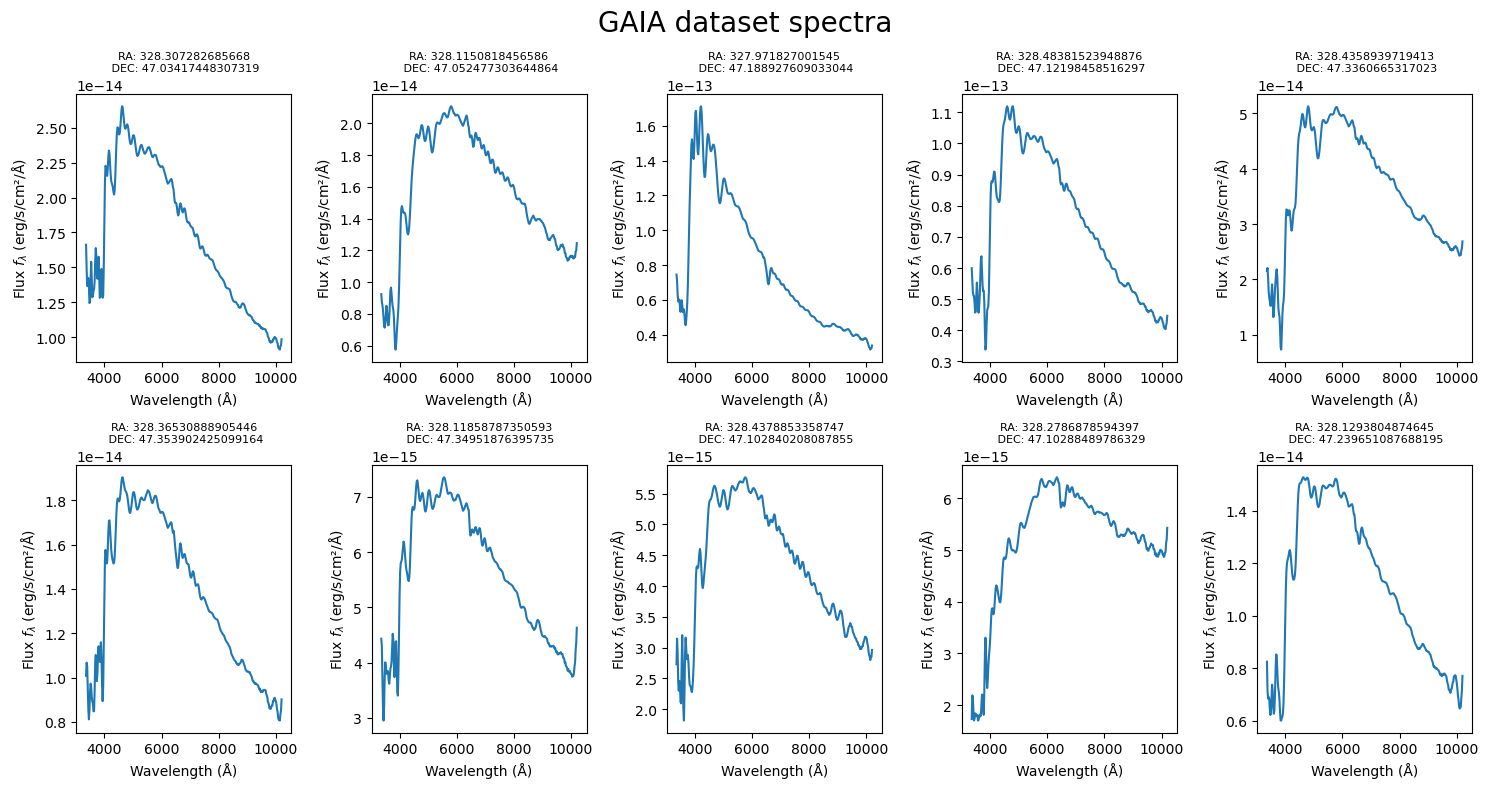

In [17]:

fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

fig.suptitle("GAIA dataset spectra",fontsize=20)

for i in range(10):
    star = stars_gaia[i]
    axes[i].plot(star['wavelength'], star['flux'])
    axes[i].set_ylabel('Flux $f_\lambda$ (erg/s/cm²/Å)', fontsize=10)
    axes[i].set_xlabel('Wavelength (Å)', fontsize=10)
    axes[i].set_title(f"RA: {star['ra']}\n DEC: {star['dec']}",fontsize=8)

plt.tight_layout()
plt.show()


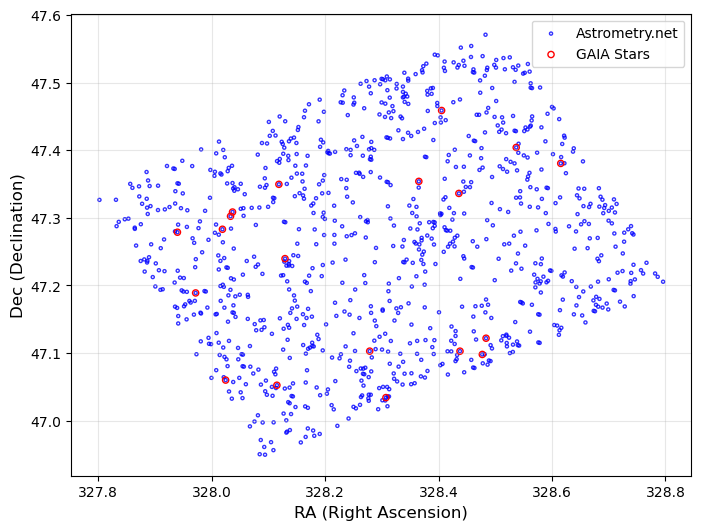

In [18]:
# Extract RA and Dec for GAIA stars from the dictionary

gaia_ra = [star['ra'] for star in stars_gaia]
gaia_dec = [star['dec'] for star in stars_gaia]
astrometry_ra = [star['ra'] for star in stars_astrometry]
astrometry_dec = [star['dec'] for star in stars_astrometry]

# Plot the scatter plots
plt.figure(figsize=(8, 6))  # Optional: Set figure size for better visualization
plt.scatter(astrometry_ra, astrometry_dec, edgecolors='blue', facecolors='none', s=5, alpha=0.8, label='Astrometry.net')
plt.scatter(gaia_ra, gaia_dec, edgecolors='red', facecolors='none', s=20, label='GAIA Stars')

# Add labels and legend
plt.xlabel('RA (Right Ascension)', fontsize=12)
plt.ylabel('Dec (Declination)', fontsize=12)
plt.legend(loc='best')  # Add a legend to differentiate datasets
plt.grid(alpha=0.3)  # Optional: Add a light grid for better readability

# Show the plot
plt.show()


***Choice of aperture***

Write something

In [19]:
# select those stars present both in astrometry.net and in sdss

stars_calib = []  # This will store the list of stars with all properties

#create aperture to measure the counts/s of each star

from photutils.aperture import CircularAperture, aperture_photometry
from photutils.centroids import centroid_com
from astropy.modeling import models, fitting

# centroid_com (Center of Mass): 
# Uses the weighted average of pixel intensities.
# Assumes the brightest part of the image corresponds to the object's center.
# Sensitive to noise and nearby objects but works well for symmetric and isolated stars.

# centroid_quadratic:
# Fits a 2D quadratic function (paraboloid) to the pixel intensities around the peak.
# Finds the peak position analytically based on the quadratic fit.
# More accurate for well-sampled peaks, but requires the peak to be well-defined and isolated.


# Loop through each star in astrometry_stars_array
# ASTROMETRY WITH GAIA

for i in range(len(stars_astrometry)):  
    for j in range(len(stars_gaia)):  
        
        # Match RA/Dec with a tolerance
        if np.isclose(stars_astrometry[i]['ra'], stars_gaia[j]['ra'], atol=1e-5, rtol=1e-6) and \
           np.isclose(stars_astrometry[i]['dec'], stars_gaia[j]['dec'], atol=1e-5, rtol=1e-6):

            
            photometry = {}  
            for f in filter:  
                l = 20 
                rectangle = image[f][int(stars_astrometry[i]['y'] - l):int(stars_astrometry[i]['y'] + l), 
                                                int(stars_astrometry[i]['x'] - l):int(stars_astrometry[i]['x'] + l)]
                
                y, x = np.mgrid[:rectangle.shape[0], :rectangle.shape[1]]
                g_init = models.Gaussian2D(amplitude=rectangle.max(), x_mean=l, y_mean=l, x_stddev=5, y_stddev=5)
                fit = fitting.LevMarLSQFitter()
                g_fit = fit(g_init, x, y, rectangle)
            
                refined_x = stars_astrometry[i]['x'] - l + g_fit.x_mean.value
                refined_y = stars_astrometry[i]['y'] - l + g_fit.y_mean.value

                sigma_x, sigma_y = g_fit.x_stddev.value, g_fit.y_stddev.value
                fwhm_x = 2.355 * sigma_x
                fwhm_y = 2.355 * sigma_y
                fwhm = (fwhm_x + fwhm_y) / 2
            
                # Create a CircularAperture object with a radius of 3 times the FWHM
                # Why 3 times the FWHM? This is a common choice to include most of the star's light.
                aperture = CircularAperture((refined_x, refined_y), r = 3 * fwhm)
                phot_table = aperture_photometry(image[f], aperture)   # why it doesn't work on rectangle ??

                photometry[f] = {
                    'counts_s': phot_table['aperture_sum'][0],  # Flux
                    'centroid': (refined_x, refined_y),         # Centroid
                    'aperture': 3  * fwhm,                      # photomoetric aperture is 3 times the FWHM  (Why?)
                }

            true_specific_flux_lambda_gaia = {}  
            true_mag_gaia = {}
            true_mag_sdss = {}
            for f in filter: 
                true_specific_flux_lambda_gaia[f] = specific_flux_lambda(stars_gaia[j]['wavelength'],stars_gaia[j]['flux'],filter_transmission[f]['wavelength'],filter_transmission[f]['transmission'])
                true_mag_gaia[f] = magnitude(stars_gaia[j]['wavelength'],stars_gaia[j]['flux'],filter_transmission[f]['wavelength'],filter_transmission[f]['transmission'])
                true_mag_sdss[f] = globals()[f"TOBI_{f}"](
                    stars_sdss[j]['r'], 
                    stars_sdss[j]['g' if f in ['Ha', 'Hb', 'g', 'r'] else 'i']
                )

            stars_calib.append({
                'x': stars_astrometry[i]['x'],
                'y': stars_astrometry[i]['y'],
                'ra': stars_astrometry[i]['ra'],
                'dec': stars_astrometry[i]['dec'],
                'photometry': photometry,
                'true_specific_flux_lambda_gaia': true_specific_flux_lambda_gaia,
                'true_mag_gaia': true_mag_gaia, 
                'true_mag_sdss': true_mag_sdss   
            })

    print(fwhm)
            

In [20]:
import pandas as pd

# Prepare a list to store the rows of the table
table_data = []

# Loop through the stars_calib list to extract the necessary data
for star in stars_calib:
    # Extract the RA and DEC
    ra = star['ra']
    dec = star['dec']
    
    # Extract the true specific flux for each filter (r, g, i)
    flux_r = star['true_specific_flux_lambda_gaia']['r']
    flux_g = star['true_specific_flux_lambda_gaia']['g']
    flux_i = star['true_specific_flux_lambda_gaia']['i']
    
    # Extract the true magnitudes for each filter (r, g, i)
    mag_gaia_r = star['true_mag_gaia']['r']
    mag_gaia_g = star['true_mag_gaia']['g']
    mag_gaia_i = star['true_mag_gaia']['i']
    
    # Extract the true magnitudes for SDSS (r, g, i)
    mag_sdss_r = star['true_mag_sdss']['r']
    mag_sdss_g = star['true_mag_sdss']['g']
    mag_sdss_i = star['true_mag_sdss']['i']
    
    # Append the row to the table data list
    table_data.append([ra, dec, flux_r, flux_g, flux_i, mag_gaia_r, mag_gaia_g, mag_gaia_i, mag_sdss_r, mag_sdss_g, mag_sdss_i])

# Create a DataFrame to display the table
columns = ['RA', 'DEC', 'True Specific Flux (r)', 'True Specific Flux (g)', 'True Specific Flux (i)',
           'True Mag GAIA (r)', 'True Mag GAIA (g)', 'True Mag GAIA (i)', 
           'True Mag SDSS (r)', 'True Mag SDSS (g)', 'True Mag SDSS (i)']
df = pd.DataFrame(table_data, columns=columns)

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Increase width for large data
pd.set_option('display.max_colwidth', None)  # Don't truncate content in columns
pd.set_option('display.max_rows', None)  # Display all rows (optional)

# Print the entire table with a smaller font size
#print(df.to_string(index=False))

from IPython.display import display, HTML

# Display the DataFrame with scrollable view
display(HTML('<style>.dataframe{width:100%; height:400px; overflow:auto;}</style>'))
display(df)


RA        DEC  True Specific Flux (r)  True Specific Flux (g)  True Specific Flux (i)  True Mag GAIA (r)  True Mag GAIA (g)  True Mag GAIA (i)  True Mag SDSS (r)  True Mag SDSS (g)  True Mag SDSS (i)
0   327.971857  47.188921            9.177351e-14            1.298330e-13            5.976205e-14          11.223355          11.388774          11.252142          14.149167          14.140526          16.343598
1   328.436048  47.336052            4.892871e-14            4.280069e-14            3.859362e-14          11.906239          12.593610          11.726917          14.129636          14.343280          14.438256
2   328.483803  47.121988            9.575820e-14            9.774953e-14            7.129959e-14          11.177208          11.696950          11.060488          14.390959          14.702905          14.771337
3   328.019071  47.283059            3.467930e-14            1.924939e-14            3.680266e-14          12.279972          13.461194          11.778508          14.085703          14.289606          16.481047
4   328.307334  47.034177            2.162746e-14            2.300443e-14            1.602878e-14          12.792634          13.267708          12.680954          14.760106          14.905558          14.688454
5   328.365300  47.353882            1.719817e-14            1.715626e-14            1.335588e-14          13.041442          13.586180          12.879025          14.516075          14.665956          15.662368
6   328.405395  47.458661            3.335288e-14            3.320606e-14            2.523843e-14          12.322315          12.869193          12.188050          14.032727          14.378326          15.946337
7   328.129489  47.239656            1.439992e-14            1.383515e-14            1.119139e-14          13.234248          13.819777          13.070996          14.140672          14.494241          14.046054
8   328.536991  47.404022            1.991956e-14            2.014075e-14            1.586559e-14          12.881948          13.412048          12.692065          14.298569          14.667193          15.807073
9   328.278660  47.102917            6.311106e-15            4.914882e-15            5.885164e-15          14.129884          14.943454          13.768809          14.685955          14.272594          16.305772
10  328.615533  47.380474            1.870613e-14            1.870503e-14            1.466441e-14          12.950188          13.492340          12.777544          14.569568          14.938193          14.384877
11  328.024748  47.060036            2.457622e-14            2.433657e-14            1.918889e-14          12.653860          13.206588          12.485581          14.295203          14.716963          14.154374
12  328.115132  47.052458            2.038193e-14            1.768515e-14            1.682444e-14          12.857035          13.553215          12.628354          14.171984          14.335149          14.105759
13  328.118642  47.349526            6.916071e-15            6.563344e-15            5.680660e-15          14.030499          14.629424          13.807209          14.265562          14.635072          16.610063
14  328.477125  47.098008            7.090834e-15            5.912774e-15            6.291338e-15          14.003405          14.742758          13.696348          14.363191          14.641484          13.877642
15  328.036942  47.308540            9.611504e-15            8.356237e-15            7.802666e-15          13.673170          14.367210          13.462598          14.940035          14.224685          15.346225
16  328.437852  47.102868            5.510568e-15            5.063406e-15            4.460444e-15          14.277157          14.911130          14.069760          14.452178          14.877481          16.497889
17  328.033372  47.302285            7.145859e-15            6.346640e-15            5.713411e-15          13.995012          14.665877          13.800967          14.205819          14.392895    

**INSTRUMENTAL RESPONSE**

C depends on the instrument and on the FILTER. It changes with time, mainly because of dust. Converts a flux in erg/cm^2s^1A^2 in electron per second rate. Analogic digital converter then gives DU. C is called ZERO POINT. 

$$f_\lambda = 10^{-C} N_e$$   integrated over the band

taking the log and multiplying left and right by -2.5:

$$-2.5\log(f_\lambda) = 2.5C - 2.5\log(N_e)$$

the term on left is the apparent magnitude of the source (real flux), while the first term on right is referred to as "zero point" and the second term as instrument magnitude:

$$m_{true} = Z.P. + m_i$$

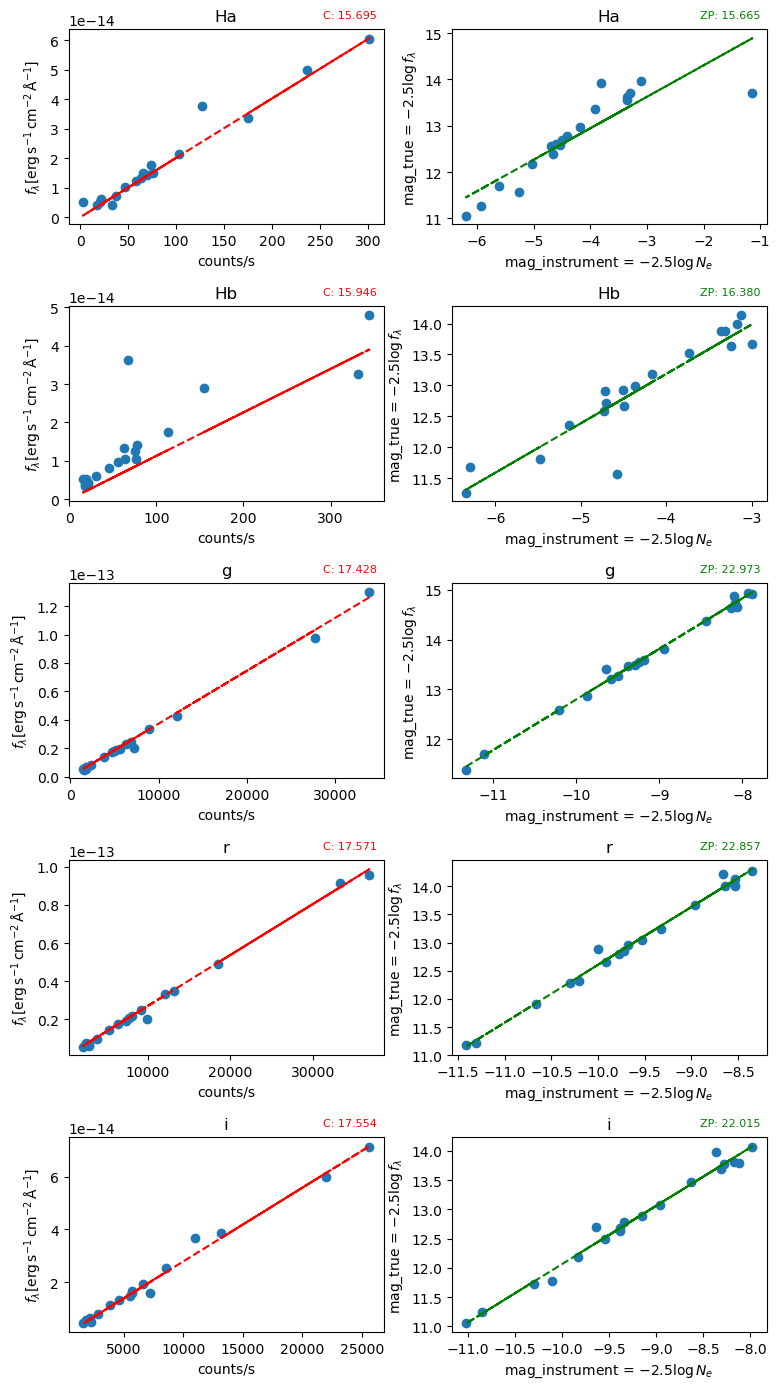

In [21]:
from scipy.stats import linregress

# Extract flux values from stars_calib

fig, ax = plt.subplots(5,2,figsize=(8, 14))

C = {}
ZP = {}

for i, f in enumerate(filter):
    ax[i][0].set_title(f)
    ax[i][1].set_title(f)
    
    specific_flux_lambda_true = [star['true_specific_flux_lambda_gaia'][f] for star in stars_calib]
    counts_s = [star['photometry'][f]['counts_s'] for star in stars_calib]
    ax[i][0].plot(counts_s, specific_flux_lambda_true, 'o')
    ax[i][0].set_xlabel('counts/s')
    ax[i][0].set_ylabel('${f_\lambda} [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1}}]$')
    
    # Compute linear fit
    slope, intercept, _, _, _ = linregress(counts_s, specific_flux_lambda_true)
    fit_line = slope * np.array(counts_s) 

    # slope is 10^-C
    C[f] = -np.log10(slope)

    # Plot linear fit line
    ax[i][0].plot(counts_s, fit_line, '--', color='red')
    
    # Slope: {slope:.3f}\n
    text = f"C: {C[f]:.3f}"
    ax[i][0].text(0.98, 1.1, text, fontsize=8, color='red',
               transform=ax[i][0].transAxes, ha='right', va='top')

    # magnitudes
    mag_true = [star['true_mag_gaia'][f] for star in stars_calib]
    mag_instrument = -2.5 * np.log10(counts_s)
    
    ax[i][1].plot(mag_instrument, mag_true, 'o')
    ax[i][1].set_xlabel('mag_instrument = $-2.5\log{N_e}$')
    ax[i][1].set_ylabel('mag_true = $-2.5\log{f_\lambda}$')

    # Compute linear fit
    slope, intercept, _, _, _ = linregress(mag_instrument,mag_true)
    fit_line_mag = slope * np.array(mag_instrument) + intercept 

    # ZP is the intercept
    ZP[f] = intercept

    # Plot linear fit line
    ax[i][1].plot(mag_instrument, fit_line_mag, '--', color='green')
    
    text = f"ZP: {ZP[f]:.3f}"
    ax[i][1].text(0.98, 1.1, text, fontsize=8, color='green',
               transform=ax[i][1].transAxes, ha='right', va='top')


plt.tight_layout()
plt.show()

## Surface Brightness

If we express specific surface brightness in terms of angular units, we are essentially looking at the amount of flux emitted per unit area on the sky, normalized by the solid angle corresponding to the angular size of the source.

The typical unit for specific surface brightness in terms of arcseconds squared is:

Units of Specific Surface Brightness (per unit wavelength, in $\mathrm{arcsec^{-2}}$):

$$[I_\lambda] = \mathrm{erg\, s^{-1}\, cm^{-2}\, \mathring{A}^{-1}\, arcsec^{-2}}$$




***Flux and Intensity***
The relationship between flux and intensity depends on the geometry of the system, particularly the solid angle over which the radiation is spread. The specific flux $f_\nu$ observed at a given point is related to the specific intensity $I_\nu$ integrated over the solid angle subtended by the source.

If $\Omega$ is the solid angle (in steradians) subtended by the source at the observer, then:

$$f_\nu = I_\nu \cdot \Omega$$

***Surface Brightness and Intensity***
The specific surface brightness $I_\nu$ at a point on the sky is just the specific intensity measured in units of area per unit solid angle, normalized to the area of the sky:

- For a point source, the intensity $I_\nu$ is the same as the surface brightness.
- For an extended source (such as a galaxy), the surface brightness refers to the intensity per unit area on the sky (e.g., per arcsecond squared), while intensity refers to the intrinsic brightness of the source in terms of physical area and solid angle.


***Surface Brightness and Flux in Annuli or Apertures***
In the case of extended sources, you might calculate the total flux in an aperture (e.g., in circular annuli) by integrating the specific surface brightness $I_\nu$ over the area of the aperture (projected onto the sky).

For an annular region with angular dimensions $\theta_{\mathrm{in}}$ and $\theta_{\mathrm{out}}$, the flux can be calculated as:

$$text{Total Flux} = \int_{\theta_{\mathrm{in}}}^{\theta_{\mathrm{out}}} I_\nu \, d\Omega$$


where $d\Omega = \sin(\theta) d\theta d\phi$ is the differential solid angle in spherical coordinates.



In [1]:
# surface brightness 
# Devide by the area of each pixel

angular_size_pixel_TOBI = 0.44  # arcesc per pixel
solid_angle_pixel_TOBI = angular_size_pixel_TOBI**2 # arcsec^2 per pixel

image_cal = {}

for i, f in enumerate(filter):
    
    image_cal[f] = 10**-C[f] * image[f] / solid_angle_pixel_TOBI
    

NameError: name 'angular_size_pixel_TOBI' is not defined

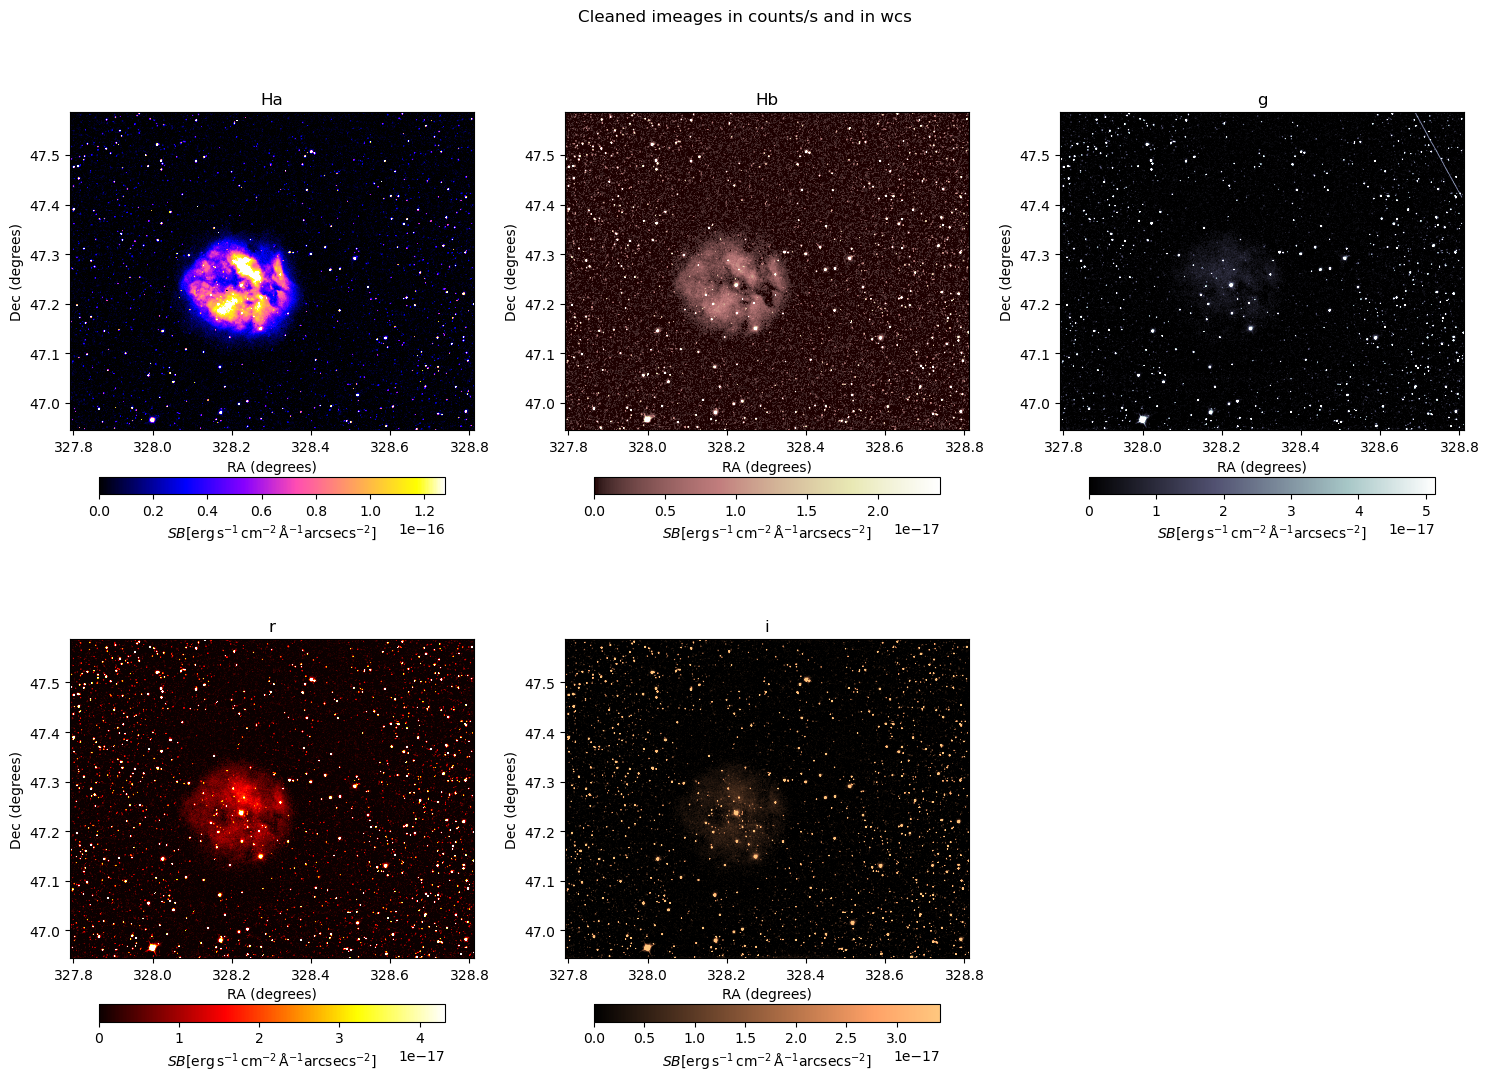

In [25]:
# Plotting CALIBRATED images with celestial coordinates

fig, axes = plt.subplots(2, 3, figsize=(15, 11))
fig.suptitle("Cleaned imeages in counts/s and in wcs")
axes = axes.flatten()

for i, f in enumerate(filter):
    im = axes[i].imshow(image_cal[f], clim=[0, np.quantile(image_cal[f], 0.99)], 
                        cmap=filter_cmap[f], origin='lower', extent=[RA.min(), RA.max(), Dec.min(), Dec.max()])
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1, label="$SB  [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1} arcsecs^{-2}}]$")
    axes[i].set_title(f)
    axes[i].set_xlabel("RA (degrees)")
    axes[i].set_ylabel("Dec (degrees)")

    axes[i].set_aspect(nx/ny)

axes[-1].axis('off')

plt.tight_layout()
plt.show()


In [35]:
output_folder = "data/cleaned_calibrated"

# Loop through each filter's image data
for f in filter:

    # Create the FITS file path
    fit_filename = os.path.join(output_folder, f"{f}_calibrated.fit")

    # Primary HDU: The science image
    primary_hdu = fits.PrimaryHDU(data=image_cal[f])

    # RA and Dec HDUs: Save RA and Dec arrays as extensions
    ra_hdu = fits.ImageHDU(data=RA, name='RA')
    dec_hdu = fits.ImageHDU(data=Dec, name='DEC')

    # Create an HDUList to combine all HDUs
    hdul = fits.HDUList([primary_hdu, ra_hdu, dec_hdu])
    
    # Save the calibrated filter as a FITS file
    hdul.writeto(fit_filename, overwrite=True)

    

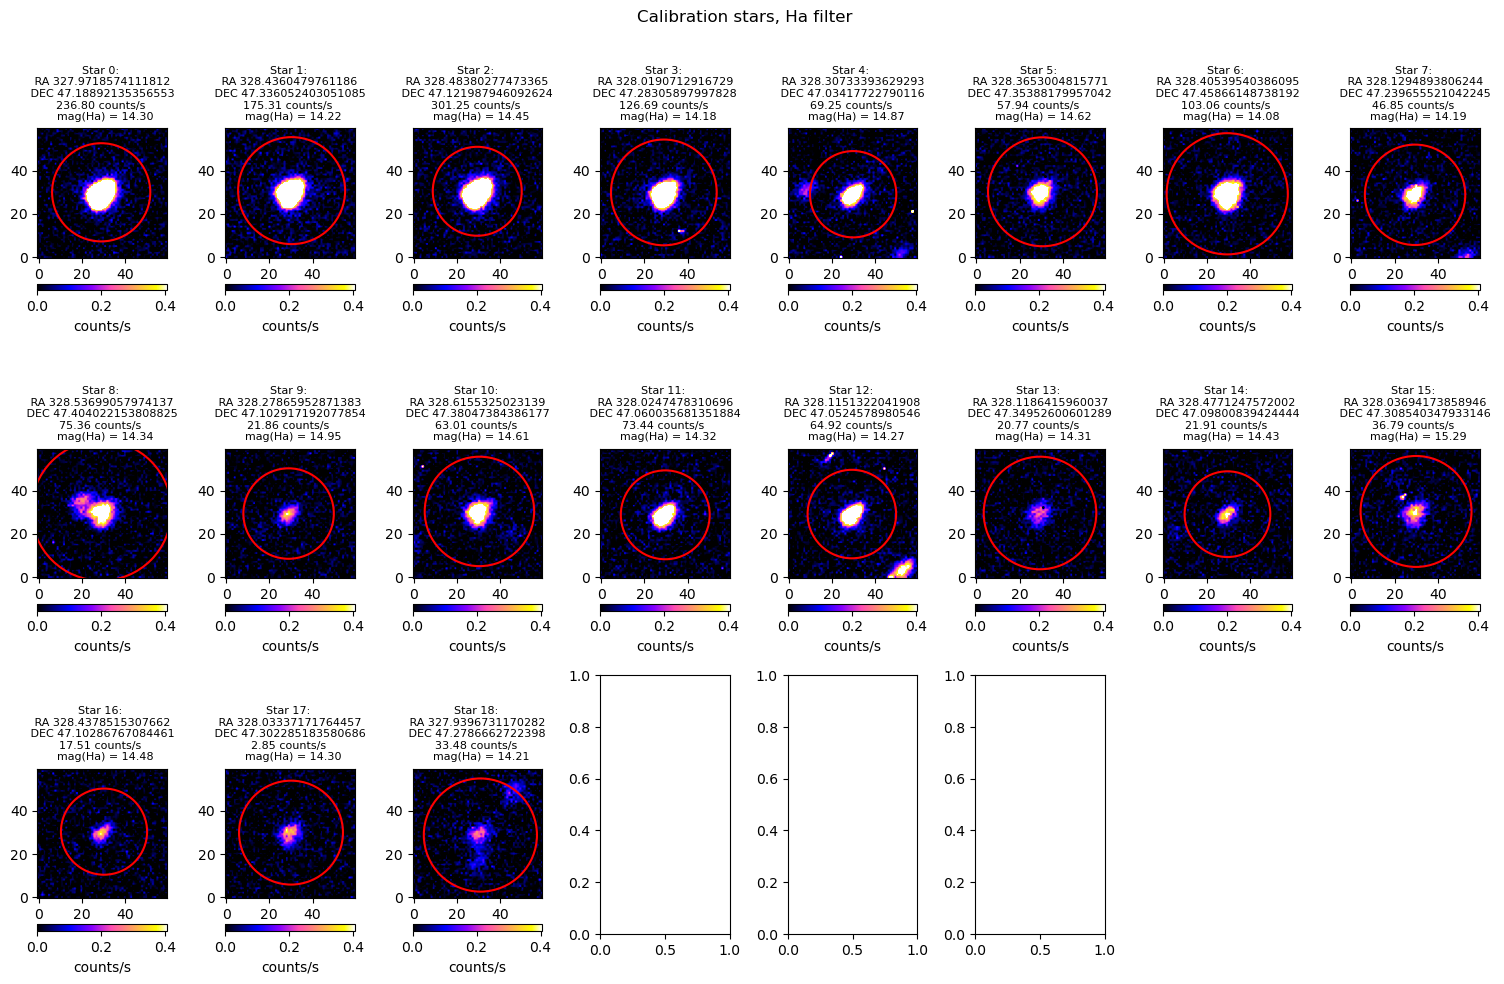

In [31]:

from matplotlib.patches import Circle

N = len(stars_calib)

filter_name = 'Ha'

cmax = np.quantile(image[filter_name],0.999)


fig, axes = plt.subplots(int(N/8)+1, 8, figsize=(15, 10))
fig.suptitle(f"Calibration stars, {filter_name} filter")
axes = axes.flatten()


cmax = np.quantile(image[filter_name],0.999)

for i in range(N):

    l = 30
    x_sx = int(stars_calib[i]['x']-l)
    x_dx = int(stars_calib[i]['x']+l)
    y_sx = int(stars_calib[i]['y']-l)
    y_dx = int(stars_calib[i]['y']+l)
    rectangle = image[filter_name][y_sx:y_dx, x_sx:x_dx]

    #print(rectangle.shape)
    #print(np.mean(rectangle))
    #print(np.max(rectangle))
    #print(np.sum(rectangle))
    
    im = axes[i].imshow(rectangle, clim=[0, cmax], cmap=filter_cmap[filter_name], origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1, label="counts/s")
    
    # Retrieve refined_x, refined_y, and radius r
    refined_x = stars_calib[i]['photometry'][filter_name]['centroid'][0] - x_sx
    refined_y = stars_calib[i]['photometry'][filter_name]['centroid'][1] - y_sx
    fwhm = stars_calib[i]['photometry'][filter_name]['aperture']

    # Draw the circle
    circle = Circle((refined_x, refined_y), fwhm, edgecolor='red', facecolor='none', linewidth=1.5)
    axes[i].add_patch(circle)

    aperture_sum = stars_calib[i]['photometry'][filter_name]['counts_s']
    axes[i].set_title(f"Star {i}: \n RA {stars_calib[i]['ra']} \n DEC {stars_calib[i]['dec']} \n{aperture_sum:.2f} counts/s \n  mag({filter_name:s}) = {stars_calib[i]['true_mag_sdss'][filter_name]:.2f}", fontsize=8)
    

for i in range(1,N%8): axes[-i].axis('off')

plt.tight_layout()
plt.show()


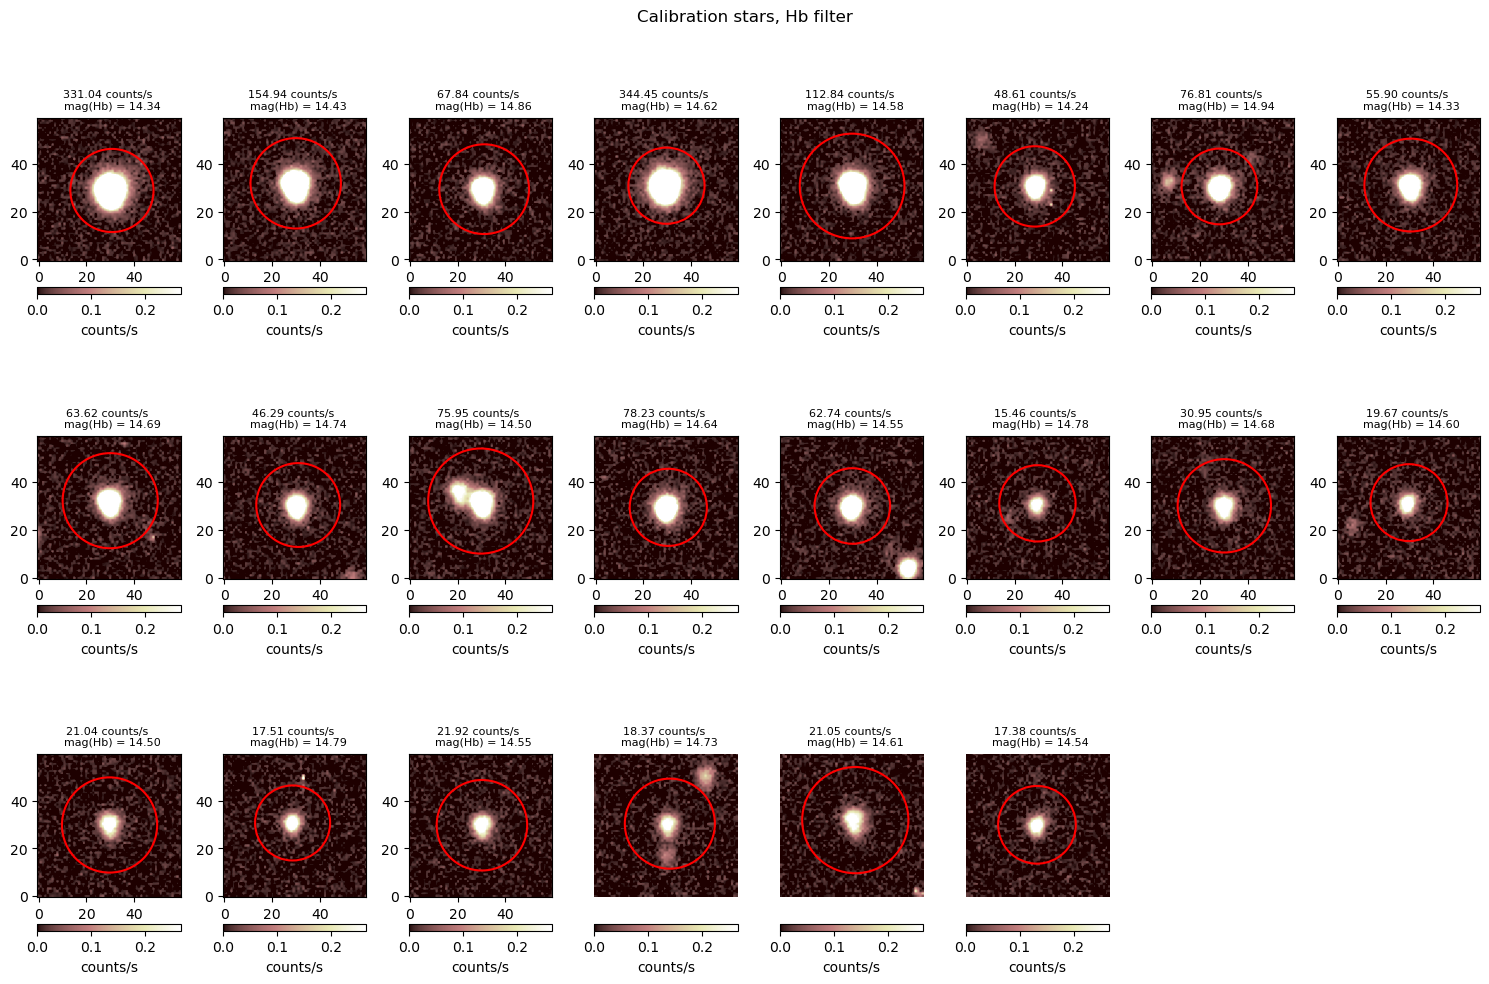

In [42]:
N = len(stars_calib)

filter_name = 'Hb'

cmax = np.quantile(filters_aligned[filter_name],0.999)


fig, axes = plt.subplots(int(N/8)+1, 8, figsize=(15, 10))
fig.suptitle(f"Calibration stars, {filter_name} filter")
axes = axes.flatten()


cmax = np.quantile(filters_aligned[filter_name],0.999)

for i in range(N):

    l = 30
    x_sx = int(stars_calib[i]['x']-l)
    x_dx = int(stars_calib[i]['x']+l)
    y_sx = int(stars_calib[i]['y']-l)
    y_dx = int(stars_calib[i]['y']+l)
    rectangle = filters_aligned[filter_name][y_sx:y_dx, x_sx:x_dx]

    #print(rectangle.shape)
    #print(np.mean(rectangle))
    #print(np.max(rectangle))
    #print(np.sum(rectangle))
    
    im = axes[i].imshow(rectangle, clim=[0, cmax], cmap=filter_cmap[filter_name], origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1, label="counts/s")
    
    # Retrieve refined_x, refined_y, and radius r
    refined_x = stars_calib[i]['photometry'][filter_name]['centroid'][0] - x_sx
    refined_y = stars_calib[i]['photometry'][filter_name]['centroid'][1] - y_sx
    fwhm = stars_calib[i]['photometry'][filter_name]['aperture']

    # Draw the circle
    circle = Circle((refined_x, refined_y), fwhm, edgecolor='red', facecolor='none', linewidth=1.5)
    axes[i].add_patch(circle)

    aperture_sum = stars_calib[i]['photometry'][filter_name]['counts_s']
    axes[i].set_title(f"Star {i}\n{aperture_sum:.2f} counts/s \n  mag({filter_name:s}) = {stars_calib[i]['true_mag_tobi'][filter_name]:.2f}", fontsize=8)
    

for i in range(1,N%8): axes[-i].axis('off')

plt.tight_layout()
plt.show()

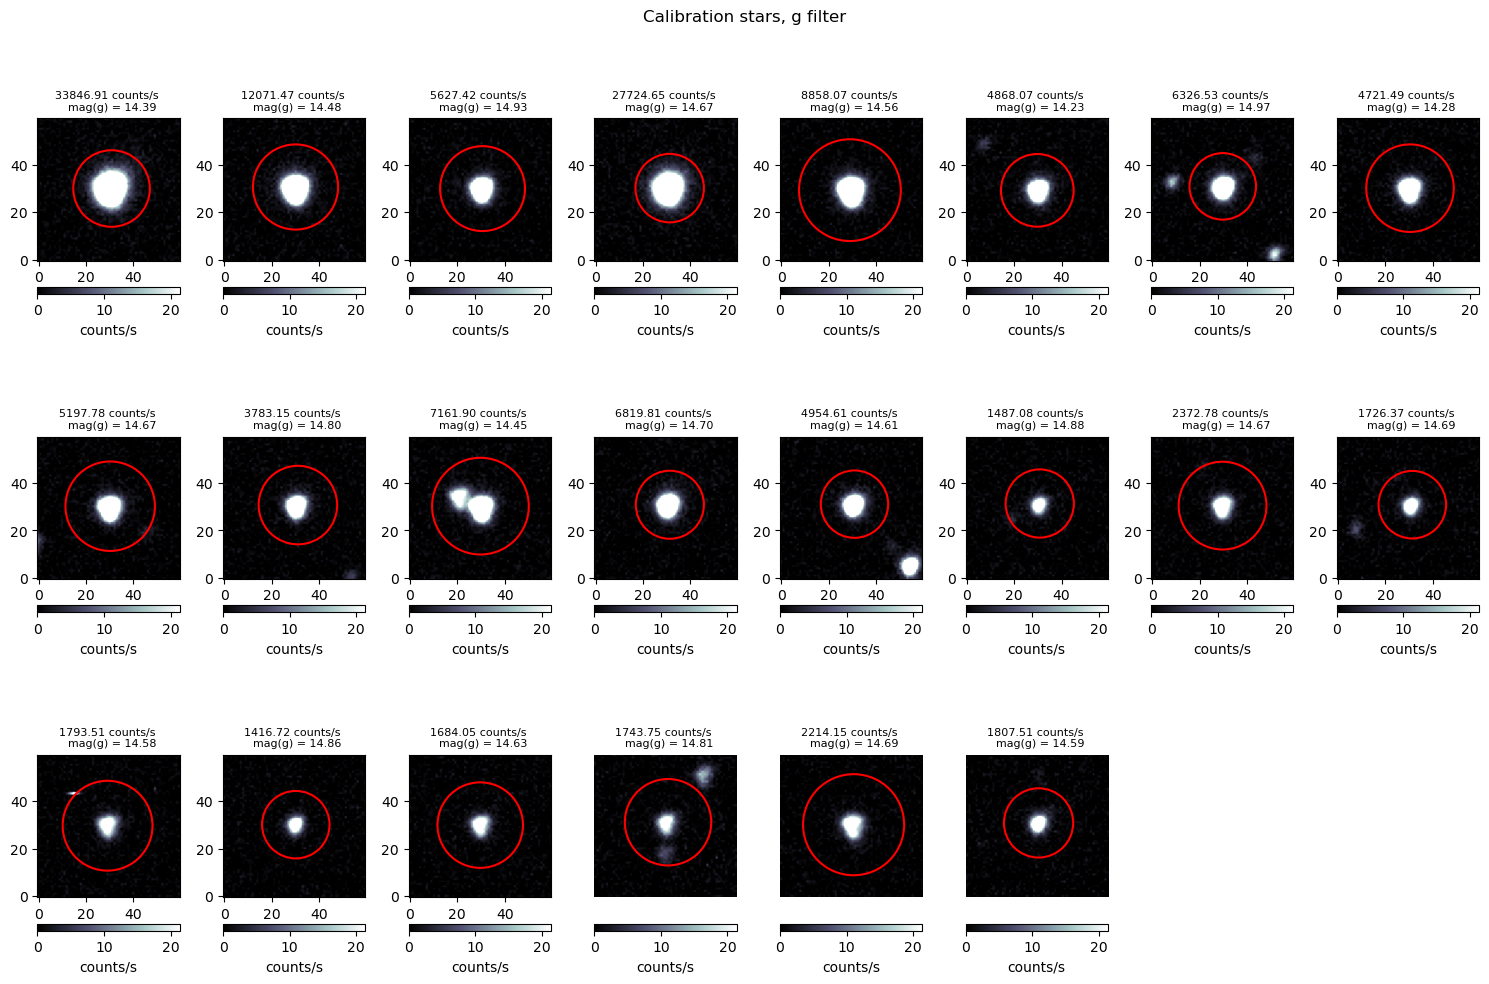

In [43]:
N = len(stars_calib)

filter_name = 'g'

cmax = np.quantile(filters_aligned[filter_name],0.999)


fig, axes = plt.subplots(int(N/8)+1, 8, figsize=(15, 10))
fig.suptitle(f"Calibration stars, {filter_name} filter")
axes = axes.flatten()


cmax = np.quantile(filters_aligned[filter_name],0.999)

for i in range(N):

    l = 30
    x_sx = int(stars_calib[i]['x']-l)
    x_dx = int(stars_calib[i]['x']+l)
    y_sx = int(stars_calib[i]['y']-l)
    y_dx = int(stars_calib[i]['y']+l)
    rectangle = filters_aligned[filter_name][y_sx:y_dx, x_sx:x_dx]

    #print(rectangle.shape)
    #print(np.mean(rectangle))
    #print(np.max(rectangle))
    #print(np.sum(rectangle))
    
    im = axes[i].imshow(rectangle, clim=[0, cmax], cmap=filter_cmap[filter_name], origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1, label="counts/s")
    
    # Retrieve refined_x, refined_y, and radius r
    refined_x = stars_calib[i]['photometry'][filter_name]['centroid'][0] - x_sx
    refined_y = stars_calib[i]['photometry'][filter_name]['centroid'][1] - y_sx
    fwhm = stars_calib[i]['photometry'][filter_name]['aperture']

    # Draw the circle
    circle = Circle((refined_x, refined_y), fwhm, edgecolor='red', facecolor='none', linewidth=1.5)
    axes[i].add_patch(circle)

    aperture_sum = stars_calib[i]['photometry'][filter_name]['counts_s']
    axes[i].set_title(f"Star {i}\n{aperture_sum:.2f} counts/s \n  mag({filter_name:s}) = {stars_calib[i]['true_mag_tobi'][filter_name]:.2f}", fontsize=8)
    

for i in range(1,N%8): axes[-i].axis('off')

plt.tight_layout()
plt.show()



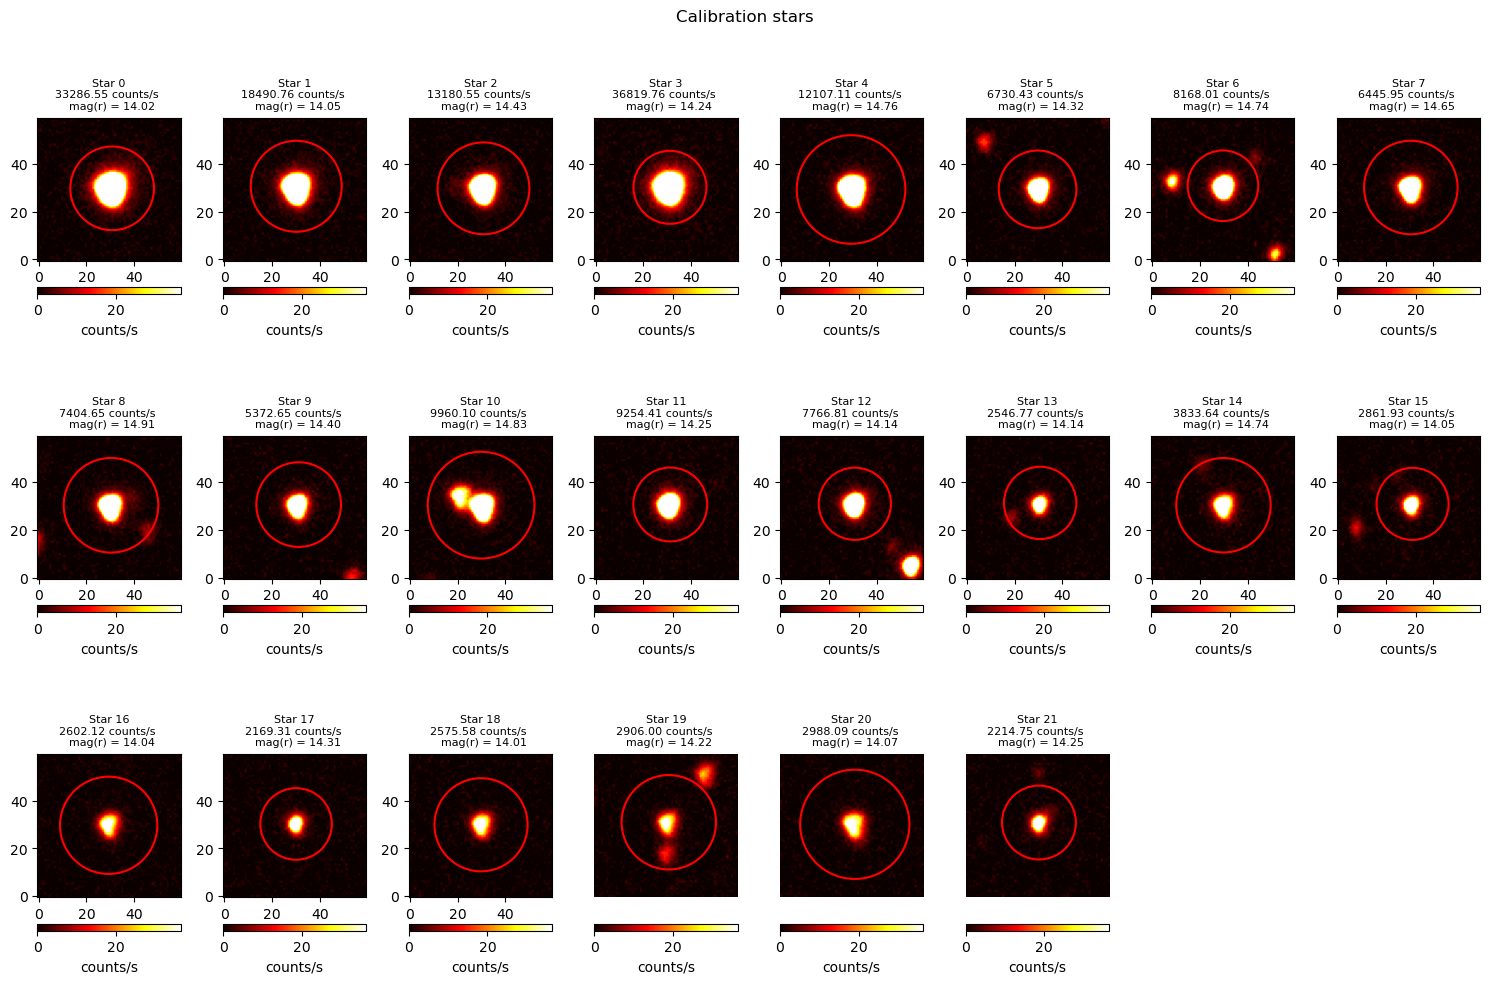

In [31]:
N = len(stars_calib)

filter_name = 'r'

cmax = np.quantile(filters_aligned[filter_name],0.999)


fig, axes = plt.subplots(int(N/8)+1, 8, figsize=(15, 10))
fig.suptitle(f"Calibration stars, {filter_name} filter")
axes = axes.flatten()

for i in range(N):

    l = 30
    x_sx = int(stars_calib[i]['x']-l)
    x_dx = int(stars_calib[i]['x']+l)
    y_sx = int(stars_calib[i]['y']-l)
    y_dx = int(stars_calib[i]['y']+l)
    rectangle = filters_aligned[filter_name][y_sx:y_dx, x_sx:x_dx]

    #print(rectangle.shape)
    #print(np.mean(rectangle))
    #print(np.max(rectangle))
    #print(np.sum(rectangle))
    
    im = axes[i].imshow(rectangle, clim=[0, cmax], cmap=filter_cmap[filter_name], origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1, label="counts/s")
    
    # Retrieve refined_x, refined_y, and radius r
    refined_x = stars_calib[i]['photometry'][filter_name]['centroid'][0] - x_sx
    refined_y = stars_calib[i]['photometry'][filter_name]['centroid'][1] - y_sx
    fwhm = stars_calib[i]['photometry'][filter_name]['aperture']

    # Draw the circle
    circle = Circle((refined_x, refined_y), fwhm, edgecolor='red', facecolor='none', linewidth=1.5)
    axes[i].add_patch(circle)

    aperture_sum = stars_calib[i]['photometry'][filter_name]['counts_s']
    axes[i].set_title(f"Star {i}\n{aperture_sum:.2f} counts/s \n  mag({filter_name:s}) = {stars_calib[i]['true_mag_tobi'][filter_name]:.2f}", fontsize=8)
    

for i in range(1,N%8): axes[-i].axis('off')

plt.tight_layout()
plt.show()


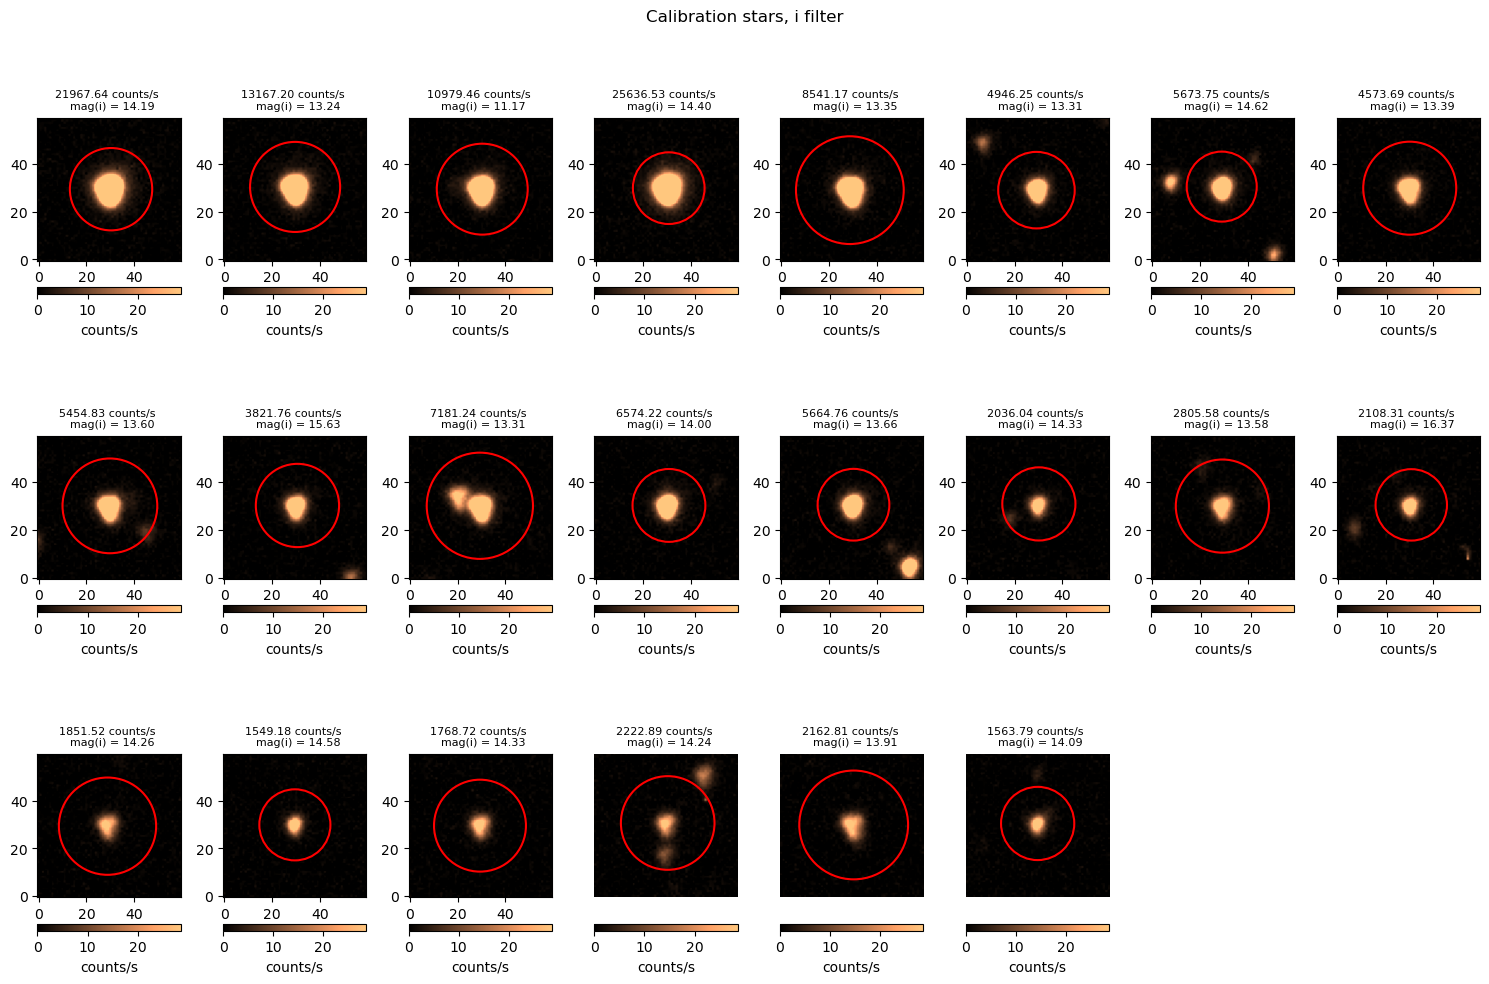

In [44]:
N = len(stars_calib)

filter_name = 'i'

cmax = np.quantile(filters_aligned[filter_name],0.999)


fig, axes = plt.subplots(int(N/8)+1, 8, figsize=(15, 10))
fig.suptitle(f"Calibration stars, {filter_name} filter")
axes = axes.flatten()


cmax = np.quantile(filters_aligned[filter_name],0.999)

for i in range(N):

    l = 30
    x_sx = int(stars_calib[i]['x']-l)
    x_dx = int(stars_calib[i]['x']+l)
    y_sx = int(stars_calib[i]['y']-l)
    y_dx = int(stars_calib[i]['y']+l)
    rectangle = filters_aligned[filter_name][y_sx:y_dx, x_sx:x_dx]

    #print(rectangle.shape)
    #print(np.mean(rectangle))
    #print(np.max(rectangle))
    #print(np.sum(rectangle))
    
    im = axes[i].imshow(rectangle, clim=[0, cmax], cmap=filter_cmap[filter_name], origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1, label="counts/s")
    
    # Retrieve refined_x, refined_y, and radius r
    refined_x = stars_calib[i]['photometry'][filter_name]['centroid'][0] - x_sx
    refined_y = stars_calib[i]['photometry'][filter_name]['centroid'][1] - y_sx
    fwhm = stars_calib[i]['photometry'][filter_name]['aperture']

    # Draw the circle
    circle = Circle((refined_x, refined_y), fwhm, edgecolor='red', facecolor='none', linewidth=1.5)
    axes[i].add_patch(circle)

    aperture_sum = stars_calib[i]['photometry'][filter_name]['counts_s']
    axes[i].set_title(f"Star {i}\n{aperture_sum:.2f} counts/s \n  mag({filter_name:s}) = {stars_calib[i]['true_mag_tobi'][filter_name]:.2f}", fontsize=8)
    

for i in range(1,N%8): axes[-i].axis('off')

plt.tight_layout()
plt.show()